# MoSDeF: A Molecular Simulation and Design Framework

The Molecular Simulation and Design Framework (MoSDeF) is a collection of open-source tools ([hosted on Github](https://github.com/mosdef-hub)) aimed at facilitating the construction and simulation of complex molecular systems - with a particular focus on the automated screening of large structural parameter spaces. All tools are written as Python packages and feature a Python-based API.

## Basic Foyer tutorial

The second of the MoSDeF tools we will explore is the [Foyer package](https://github.com/mosdef-hub/foyer) which provides a means for the automated application and dissemination of forcefields. This tool can be used to take a molecular model featuring particle positions and bonds (such as an mBuild `Compound`) and automatically perform atomtyping (as well as parameterization) as directed by a user-specified forcefield. In this tutorial, we'll demonstrate how Foyer works by using it to perform atomtyping and parameterization of several alkane molecules.

### Foyer XML format

Foyer forcefields are defined within an XML file that contains both the 'rules' required for atomtyping as well as the forcefield parameters within a single file. The Foyer XML format is an extension of the [OpenMM forcefield XML format](http://docs.openmm.org/7.0.0/userguide/application.html#creating-force-fields), which you may already be familiar with. The only differences reside in the `AtomTypes` section, where several additional attributes are available (which we will examine in a moment) for each `Type` to allow for atomtyping.

Let's take a look at the basic structure of a Foyer XML file.

#### AtomTypes

In [2]:
! sed -n 34,40p OPLSaa_perfluoroalkanes.xml

 <AtomTypes>
     <Type name="opls_961" class="CT" element="C" mass="12.01100"  def="[C;X4](F)(F)(F)(C)" desc="perfluoroalkane CF3" doi="10.1021/jp004071w"/>
     <Type name="opls_962" class="CT" element="C" mass="12.01100"  def="[C;X4](F)(F)(C)(C)" desc="perfluoroalkane CF2" doi="10.1021/jp004071w"/>
     <Type name="opls_963" class="CT" element="C" mass="12.011"    def="[C;X4](F)(C)(C)(C)" desc="perfluoroalkane CF"  doi="10.1021/jp004071w"/>
     <Type name="opls_964" class="CT" element="C" mass="12.011"    def="[C;X4](F)(F)(F)(F)" desc="perfluoroalkane CF4" doi="10.1021/jp004071w"/>
     <Type name="opls_965" class="F"  element="F" mass="18.9984"   def="FC"                 desc="perfluoroalkane F"   doi="10.1021/jp004071w"/>
 </AtomTypes>


The `AtomTypes` section of the Foyer XML is similar to that used for OpenMM forcefield XMLs; however, each `Type` in Foyer XML supports four additional attributes not found in OpenMM:
* `def` - SMARTS string describing the chemical substructure of this atomtype (Follow [this link](https://github.com/mosdef-hub/foyer/blob/master/docs/smarts.md) for more on SMARTS-based atomtyping using Foyer.)
* `desc` - Brief description of the atomtype
* `doi` - DOI reference for parameters associated with this atomtype
* `overrides` - One or more atomtypes to 'override', providing precedence to this atomtype

Atomtypes are defined using [SMARTS](http://www.daylight.com/dayhtml/doc/theory/theory.smarts.html), which provide a language for describing chemical structures and substructures.

#### Forcefield parameters

The remaining sections of the Foyer XML are currently the same as defined in the OpenMM format and feature both bonded and nonbonded forcefield parameters.

In [3]:
! sed -n 41,62p OPLSaa_perfluoroalkanes.xml

 <HarmonicBondForce>
     <Bond class1="CT" class2="CT" length="0.1529" k="224262.4"/> <!--doi="10.1021/ja9621760"-->
     <Bond class1="CT" class2="F" length="0.1332" k="307105.6"/> <!--doi="10.1002/jcc.540130806-->
 </HarmonicBondForce>
 <HarmonicAngleForce>
     <Angle class1="CT" class2="CT" class3="CT" angle="1.966986067"   k="488.273"/> <!--doi="10.1021/ja9621760"-->
     <Angle class1="CT" class2="CT" class3="F"  angle="1.91113553093" k="418.4"/>   <!--doi="10.1021/ja00124a002"-->
     <Angle class1="F"  class2="CT" class3="F"  angle="1.904154214"   k="644.336"/> <!--doi="10.1021/ja00124a002"-->
 </HarmonicAngleForce>
 <RBTorsionForce>
     <Proper class1="CT" type2="opls_962" type3="opls_962" class4="CT" c0="14.91596" c1="-22.564312" c2="-39.41328" c3="11.614784" c4="35.446848" c5="0.0"/> <!--doi="10.1021/jp004071w"-->
     <Proper type1="opls_961" type2="opls_963" type3="opls_962" type4="opls_961" c0="15.85736" c1="-19.940944" c2="-27.606032" c3="3.64008" c4="28.049536" c5="0.

### Constructing a Foyer XML

Now we'll work to construct a valid Foyer forcefield XML that can correctly parameterize linear alkanes according to the OPLS forcefield. We've provided a template XML forcefield file, where only SMARTS strings are missing and need to be defined.

Included in this example are MOL2 files for three alkane molecules (methane, ethane, and propane) that contain information as to the correct atomtypes that should be assigned to each atom, which we will use for testing and validating the forcefield file.

We'll quickly visualize the three molecules we will be atomtyping.

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


<IPython.core.display.Javascript object>


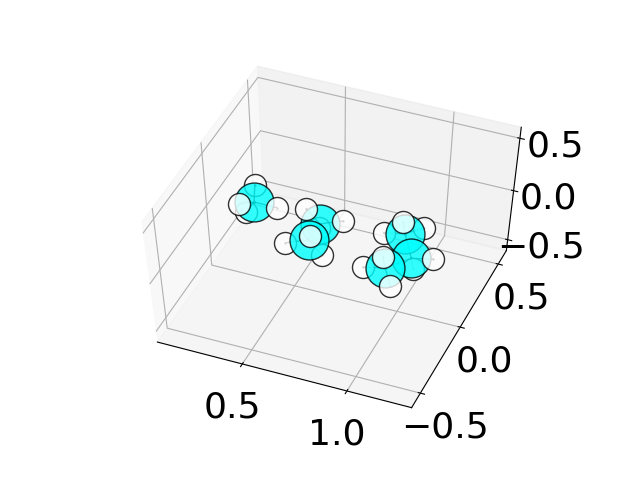

In [4]:
%matplotlib notebook
import mbuild as mb
from visualize import visualize
methane = mb.load('test_molecules/methane.mol2')
ethane = mb.load('test_molecules/ethane.mol2')
propane = mb.load('test_molecules/propane.mol2')
ethane.translate_to([0.6, 0, 0])
propane.translate_to([1, 0, 0])
alkanes = mb.Compound(subcompounds=(methane, ethane, propane))
visualize(alkanes)

In the `'forcefield.xml'` template, the `def` attribute of each atomtype features an arbitrary string (`"O"`) rather than the correct SMARTS. We will have to correctly define the SMARTS for these atomtypes for Foyer to be able to successfully parameterize each of these alkanes.

A script is provided, `test_atomtyping.py`, which will use our Foyer XML to attempt to atomtype each of the three alkane molecules and will compare the resulting atomtypes assigned by Foyer to the known atomtypes that should be assigned (read from the MOL2 files). We can use the [pytest utility](https://docs.pytest.org/en/latest/) to perform these tests.

Let's go ahead and use pytest to run `test_atomtyping.py` and see what happens.

In [7]:
! pytest -v test_atomtyping.py

============================= test session starts ==============================
platform darwin -- Python 3.5.2, pytest-3.1.1, py-1.4.32, pluggy-0.4.0 -- /Users/summeraz/anaconda/envs/py3/bin/python
cachedir: .cache
rootdir: /Users/summeraz/mosdef_workshop/foyer-examples, inifile:
collected 3 items 

test_atomtyping.py::test_atomtyping[test_molecules/ethane.mol2] FAILED
test_atomtyping.py::test_atomtyping[test_molecules/methane.mol2] FAILED
test_atomtyping.py::test_atomtyping[test_molecules/propane.mol2] FAILED

=================================== FAILURES ===================================
_________________ test_atomtyping[test_molecules/ethane.mol2] __________________

mol2_file = 'test_molecules/ethane.mol2'

    @pytest.mark.parametrize('mol2_file', MOL2_FILES)
    def test_atomtyping(mol2_file):
        structure = pmd.load_file(mol2_file, structure=True)
>       atomtype(structure, FORCEFIELD)

test_atomtyping.py:17: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Unsurprisingly, all three of our tests failed as Foyer was unable to identify any valid atomtypes for the atoms in each of our molecules. This is because none of the currently defined SMARTS for the carbon atomtypes are correct. Let's see what happens if we change the SMARTS strings for the carbons.

In SMARTS you can define a carbon with four neighbors as `'[C;X4]'`.

To edit your forcefield.xml file go back to the "Home" window that was launched when the "jupyter notebook" command was first executed and follow the steps below.
<img src="editing-forcefield.png" alt="Drawing" style="width: 850px"/>

In [ ]:
! pytest -v test_atomtyping.py

Again all three tests failed, this time because we can't differentiate between the three OPLS carbons.

Now let's distinguish these by adding to the SMARTS the number of hydrogen neighbors each OPLS carbon should have.

In [9]:
! pytest -v test_atomtyping.py

============================= test session starts ==============================
platform darwin -- Python 3.5.2, pytest-3.1.1, py-1.4.32, pluggy-0.4.0 -- /Users/summeraz/anaconda/envs/py3/bin/python
cachedir: .cache
rootdir: /Users/summeraz/mosdef_workshop/foyer-examples, inifile:
collected 3 items 

test_atomtyping.py::test_atomtyping[test_molecules/ethane.mol2] FAILED
test_atomtyping.py::test_atomtyping[test_molecules/methane.mol2] FAILED
test_atomtyping.py::test_atomtyping[test_molecules/propane.mol2] FAILED

=================================== FAILURES ===================================
_________________ test_atomtyping[test_molecules/ethane.mol2] __________________

mol2_file = 'test_molecules/ethane.mol2'

    @pytest.mark.parametrize('mol2_file', MOL2_FILES)
    def test_atomtyping(mol2_file):
        structure = pmd.load_file(mol2_file, structure=True)
>       atomtype(structure, FORCEFIELD)

test_atomtyping.py:17: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

We still have multiple types found for carbons in each molecule. However, we can add precendence to our atomtypes through the `overrides` attribute.

In [10]:
! pytest -v test_atomtyping.py

============================= test session starts ==============================
platform darwin -- Python 3.5.2, pytest-3.1.1, py-1.4.32, pluggy-0.4.0 -- /Users/summeraz/anaconda/envs/py3/bin/python
cachedir: .cache
rootdir: /Users/summeraz/mosdef_workshop/foyer-examples, inifile:
collected 3 items 

test_atomtyping.py::test_atomtyping[test_molecules/ethane.mol2] PASSED
test_atomtyping.py::test_atomtyping[test_molecules/methane.mol2] PASSED
test_atomtyping.py::test_atomtyping[test_molecules/propane.mol2] PASSED

=========================== 3 passed in 7.26 seconds ===========================


Alternatively, we can add specificity to the SMARTS without overrides, by explicitly defining all four neighbors for each atomtype. However, in some cases `overrides` are necessary to distinguish atomtypes that have the same local environment (e.g. a methyl group in toluene vs. in an alkane).

In [11]:
! pytest -v test_atomtyping.py

============================= test session starts ==============================
platform darwin -- Python 3.5.2, pytest-3.1.1, py-1.4.32, pluggy-0.4.0 -- /Users/summeraz/anaconda/envs/py3/bin/python
cachedir: .cache
rootdir: /Users/summeraz/mosdef_workshop/foyer-examples, inifile:
collected 3 items 

test_atomtyping.py::test_atomtyping[test_molecules/ethane.mol2] PASSED
test_atomtyping.py::test_atomtyping[test_molecules/methane.mol2] PASSED
test_atomtyping.py::test_atomtyping[test_molecules/propane.mol2] PASSED

=========================== 3 passed in 2.31 seconds ===========================


### Foyer + mBuild

As we saw in the mBuild tutorial, Foyer has been designed to integrate seamlessly with mBuild, although it can also be used as a standalone package. To call Foyer from mBuild all a user needs to do is specify the forcefield XML file to use by passing either the `forcefield_name` or `forcefield_files` flag to `Compound.save()`. Internally this will perform parameterization of the mBuild `Compound` using Foyer.

Additionally, the `references_file` flag can be used to output a file (in BibTeX format) containing the references for the parameters used for parameterization of this `Compound`.

Here, we explore this functionality by loading a simple methane molecule into an mBuild `Compound` and save using the forcefield we've just defined.

In [12]:
import mbuild as mb

ch4 = mb.load('ch4.pdb')
ch4.save('ch4.top', forcefield_files='forcefield_master.xml', references_file='ch4.bib', overwrite=True)

In [15]:
help(mb.Compound.save)

Help on function save in module mbuild.compound:

save(self, filename, show_ports=False, forcefield_name=None, forcefield_files=None, box=None, overwrite=False, residues=None, references_file=None, combining_rule='lorentz', **kwargs)
    Save the Compound to a file.
    
    Parameters
    ----------
    filename : str
        Filesystem path in which to save the trajectory. The extension or
        prefix will be parsed and control the format. Supported
        extensions are: 'hoomdxml', 'gsd', 'gro', 'top', 'lammps', 'lmp'
    show_ports : bool, optional, default=False
        Save ports contained within the compound.
    forcefield_file : str, optional, default=None
        Apply a forcefield to the output file using a forcefield provided
        by the `foyer` package.
    forcefield_name : str, optional, default=None
        Apply a named forcefield to the output file using the `foyer`
        package, e.g. 'oplsaa'. Forcefields listed here:
        https://github.com/mosdef-hub/

In [13]:
! cat ch4.bib

@article{Jorgensen_1996,
	doi = {10.1021/ja9621760},
	url = {https://doi.org/10.1021%2Fja9621760},
	year = 1996,
	month = {jan},
	publisher = {American Chemical Society ({ACS})},
	volume = {118},
	number = {45},
	pages = {11225--11236},
	author = {William L. Jorgensen and David S. Maxwell and Julian Tirado-Rives},
	title = {Development and Testing of the {OPLS} All-Atom Force Field on Conformational Energetics and Properties of Organic Liquids},
	journal = {Journal of the American Chemical Society},
	note = {Parameters for atom types: opls_140, opls_138}
}


## Quick-start

If you are interested in defining your existing forcefield(s) in the Foyer XML format, we currently have a forcefield template hosted on Github to help you get started - https://github.com/mosdef-hub/forcefield_template, that includes some basic scripts for validation and error checking. We also refer interested users to the [OpenMM documentation](http://docs.openmm.org/7.0.0/userguide/application.html#creating-force-fields) for detailed instructions on forcefield creation.